**MAESTRÍA EN INTELIGENCIA ARTIFICIAL APLICADA**

**Curso: TC4033 - Visión computacional para imágenes y video**

Tecnológico de Monterrey

Dr. Gilberto Ochoa Ruiz

**Semana 9**
Módulo 5. Segmentación de imágenes

9.6 Comparación de métodos de segmentación - Split & Merge

**EQUIPO 48**:

* José Alberto Rodríguez Sotomayor - A01796604
* André Maximiliano Hernández Bornn - A01795190
* César Armando Prieto Siller - A01796382
* Hector Magaña Torres - A00823440





Este notebook implementa la solución completa del algoritmo Split and Merge.

1.  **Split (División):** Se usa una estructura **Quadtree** recursiva que divide la imagen hasta que las regiones son lo suficientemente **homogéneas** (baja varianza) o pequeñas.
2.  **Merge (Fusión):** Se utiliza un proceso post-split para **fusionar** las regiones vecinas que tienen intensidades promedio similares, simplificando la segmentación.

El criterio de homogeneidad para ambas fases es la **Varianza de Intensidad**.

## Configuración y Dependencias

In [ ]:
# Importamos todas las herramientas que necesitamos
import numpy as np
import cv2
import inspect
import matplotlib.pyplot as plt
from skimage.measure import regionprops, label # Útiles para etiquetar y obtener propiedades de regiones
from skimage.segmentation import find_boundaries, relabel_sequential # Para visualizar mejor los bordes
from skimage.color import label2rgb
from skimage.segmentation import mark_boundaries
from google.colab import files
import os
import warnings
import math
warnings.filterwarnings("ignore") # Para ignorar warnings de las librerías
import heapq # Necesario para la Cola de Prioridad

## Función de criterio de homogenidad

Esta función es el **criterio fundamental** que decide si una región de la imagen es lo suficientemente 'plana' o uniforme para detener el proceso de **Split**.

Utilizamos el método de **Diferencia Máxima (Max Diff)**, que calcula la diferencia entre el píxel de mayor intensidad y el de menor intensidad dentro de la región. Si esta diferencia es menor que el `SPLIT_THRESHOLD`, la región se considera **homogénea** y se detiene la división. Si es mayor, el Quadtree continuará la división.

In [ ]:
# Definimos qué tan "plana" debe ser una región
def is_homogeneous(region, threshold):
    if region.size == 0:
        return True
    std_dev = np.std(region)
    return std_dev < threshold

# Contador global para que cada región dividida tenga un ID único
global_region_label = 0

## Funcion de split

La función **`recursive_split_quadtree`** implementa la primera fase del algoritmo, la **División**, utilizando un **Árbol Cuaternario (Quadtree)**.

El proceso es recursivo y se detiene bajo dos **casos base**:

1.  **Homogeneidad:** Si la región actual cumple con el `is_homogeneous(region, threshold)`.
2.  **Tamaño Mínimo:** Si la región ha alcanzado el `MIN_QUADRANT_SIZE` (ej., 2x2 o 4x4).

Si ninguno de los casos base se cumple, la región se divide en **cuatro cuadrantes iguales** (Top-Left, Top-Right, Bottom-Left, Bottom-Right). La función se llama a sí misma de forma recursiva en cada uno de los cuatro nuevos cuadrantes. El resultado es una máscara de etiquetas donde cada región final del Quadtree tiene un ID único.

In [ ]:
def recursive_split_quadtree(image_data, region_coords, threshold, min_size=8):
    """
    Aplica la fase de División: Divide la imagen hasta encontrar regiones homogéneas.
    """
    global global_region_label

    y_start, y_end, x_start, x_end = region_coords
    current_region = image_data[y_start:y_end, x_start:x_end]
    rows, cols = current_region.shape

    # --- CASOS BASE ---

    # 1. Caso Base de Tamaño Mínimo: No dividimos más si es muy pequeño.
    if rows <= min_size or cols <= min_size:
        global_region_label += 1
        return np.ones_like(current_region, dtype=np.uint16) * global_region_label

    # 2. Caso Base de Homogeneidad: ¡La región ya es buena, no la dividimos!
    if is_homogeneous(current_region, threshold):
        global_region_label += 1
        return np.ones_like(current_region, dtype=np.uint16) * global_region_label

    # --- DIVISIÓN (SPLIT) ---
    # Si llegamos aquí, la región es grande y no homogénea, ¡hay que partirla!
    mid_row, mid_col = rows // 2, cols // 2

    # Definimos las coordenadas de los cuatro cuadrantes
    q_coords = [
        (y_start, y_start + mid_row, x_start, x_start + mid_col), # Top-Left
        (y_start, y_start + mid_row, x_start + mid_col, x_end),   # Top-Right
        (y_start + mid_row, y_end, x_start, x_start + mid_col),   # Bottom-Left
        (y_start + mid_row, y_end, x_start + mid_col, x_end)      # Bottom-Right
    ]

    # Recipiente para los resultados de la división
    segmented_quadrants = np.zeros_like(current_region, dtype=np.uint16)

    # Llamada RECURSIVA a cada cuadrante. Aquí es donde se construye el Quadtree.
    segmented_quadrants[:mid_row, :mid_col] = recursive_split_quadtree(image_data, q_coords[0], threshold, min_size)
    segmented_quadrants[:mid_row, mid_col:] = recursive_split_quadtree(image_data, q_coords[1], threshold, min_size)
    segmented_quadrants[mid_row:, :mid_col] = recursive_split_quadtree(image_data, q_coords[2], threshold, min_size)
    segmented_quadrants[mid_row:, mid_col:] = recursive_split_quadtree(image_data, q_coords[3], threshold, min_size)

    return segmented_quadrants

## Funcion de merge

### Merge por intensidad promedio y find_boundaries

Este es el método de **fusión iterativa simple** y es el más intuitivo. Después del **Split**, la función `merge_regions` recorre todas las regiones resultantes y, para cada una, utiliza `find_boundaries` para encontrar sus regiones vecinas. Luego, se compara el **promedio de intensidad** de la región actual con el de sus vecinos. Si la diferencia es menor que el `MERGE_THRESHOLD`, se realiza la fusión.

Este proceso es **sencillo** pero **lento** para imágenes con muchas regiones, ya que encontrar los vecinos mediante `find_boundaries` y actualizar el mapa de etiquetas de forma iterativa (`new_label_map`) es computacionalmente costoso.

In [ ]:
def merge_regions(image_data, split_mask, merge_threshold, max_iter=10):
    labels = split_mask.copy()
    for it in range(max_iter):
        regions = regionprops(labels, intensity_image=image_data)
        label_to_mean = {r.label: r.mean_intensity for r in regions}
        new_labels = labels.copy()
        merged = False
        boundaries = find_boundaries(labels, mode='thick')

        yx = np.argwhere(boundaries)
        for y, x in yx:
            current = labels[y, x]
            for dy, dx in [(-1,0), (1,0), (0,-1), (0,1)]:
                ny, nx = y+dy, x+dx
                if 0 <= ny < labels.shape[0] and 0 <= nx < labels.shape[1]:
                    neighbor = labels[ny, nx]
                    if neighbor != current:
                        diff = abs(label_to_mean[current] - label_to_mean[neighbor])
                        if diff < merge_threshold:
                            new_labels[labels == neighbor] = current
                            merged = True

        labels = relabel_sequential(new_labels)[0]
        print(f"🌀 Iteración {it+1}: {labels.max()} regiones")
        if not merged:
            break
    return labels

## Funcion de Split and Merge

Generamos una función que ejecuta ambas partes del algoritmo y nos permite reutilizarla para mostrar resultados con distintas imagenes, esta primera versionr realiza merge mediante find_boundaries

In [ ]:
def run_split_merge_and_graph(image_path, split_threshold, merge_threshold, min_quadrant_size=8,max_iter=5):
    """
    Ejecuta el proceso Split & Merge con visualización clara:
    - Imagen original
    - Resultado del split (coloreado)
    - Resultado del merge (coloreado + bordes rojos)
    """

    # 0. INICIALIZACIÓN
    global global_region_label
    global_region_label = 0  # Reinicia el contador de etiquetas

    # --- Cargar imagen y suavizar ---
    original_img = cv2.imread(image_path)
    if original_img is None:
        print(f"❌ Error: No se pudo cargar la imagen en la ruta {image_path}")
        return

    gray = cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (3, 3), 0)

    # --- SPLIT ---
    print("🔹 Ejecutando Split...")
    split_mask = recursive_split_quadtree(
        blurred,
        (0, blurred.shape[0], 0, blurred.shape[1]),
        split_threshold,
        min_quadrant_size
    )
    n_split = split_mask.max()
    print(f"✅ Split completado con {n_split} regiones")

    # --- MERGE ---
    print("🔹 Ejecutando Merge optimizado...")
    input_for_merge = split_mask.copy()
    merged_mask = merge_regions(blurred, input_for_merge, merge_threshold,max_iter)
    merged_mask = relabel_sequential(merged_mask)[0]
    n_merge = merged_mask.max()
    print(f"✅ Merge completado con {n_merge} regiones")

    # --- VISUALIZACIÓN ---
    image_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

    # Coloreamos regiones según la imagen original
    colored_split = label2rgb(split_mask, image=image_rgb, kind='avg', saturation=1)
    colored_merge = label2rgb(merged_mask, image=image_rgb, kind='avg', saturation=1)

    # Añadimos bordes para enfatizar regiones
    image_split_with_edges = mark_boundaries(colored_split, split_mask, color=(0, 1, 0), mode='thick')
    image_merge_with_edges = mark_boundaries(colored_merge, merged_mask, color=(1, 0, 0), mode='thick')

    # --- Creación de Subplots ---
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    ax = axes.ravel()

    ax[0].imshow(image_rgb)
    ax[0].set_title("1️⃣ Imagen Original")
    ax[0].axis('off')

    ax[1].imshow(image_split_with_edges)
    ax[1].set_title(f"2️⃣ Resultado SPLIT ({n_split} Regiones)")
    ax[1].axis('off')

    ax[2].imshow(image_merge_with_edges)
    ax[2].set_title(f"3️⃣ Resultado MERGE ({n_merge} Regiones)")
    ax[2].axis('off')

    plt.tight_layout()
    plt.show()

    return split_mask, merged_mask

## Ejecucion del algoritmo

### Variables globales

Defininimos variables globales para las pruebas, estas se modificaran en base prueba y error. Al hacerlas globales utilizamos los mismos parametros en cada ejecución y podemos actualizarlos en conjunto para hacer distintas pruebas

In [ ]:
# Umbral de Varianza (Split): Qué tan estricto para la división inicial.
# Un valor bajo (ej. 50-100) fuerza la división en áreas de bajo contraste.
SPLIT_THRESHOLD = 50

# Umbral de Intensidad Media (Merge): Qué tan parecidas deben ser las regiones adyacentes
# para fusionarse. La intensidad va de 0 a 255.
# Un valor de 10-20 es una buena diferencia para fusionar.
MERGE_THRESHOLD = 20

# Tamaño Mínimo: Para evitar recursión infinita en áreas muy pequeñas.
MIN_QUADRANT_SIZE = 16

MAX_ITER=6

### León

🔹 Ejecutando Split...
✅ Split completado con 49 regiones
🔹 Ejecutando Merge optimizado...
🌀 Iteración 1: 39 regiones
🌀 Iteración 2: 31 regiones
🌀 Iteración 3: 24 regiones
🌀 Iteración 4: 22 regiones
🌀 Iteración 5: 21 regiones
🌀 Iteración 6: 20 regiones
✅ Merge completado con 20 regiones


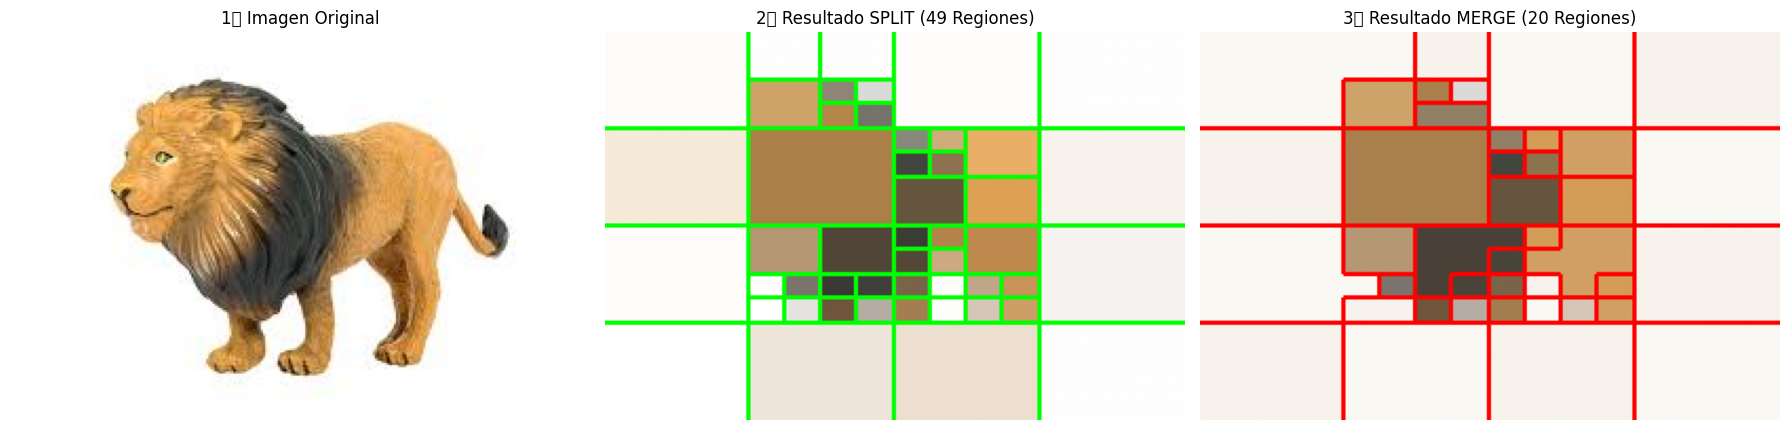

(array([[ 1,  1,  1, ..., 12, 12, 12],
        [ 1,  1,  1, ..., 12, 12, 12],
        [ 1,  1,  1, ..., 12, 12, 12],
        ...,
        [32, 32, 32, ..., 49, 49, 49],
        [32, 32, 32, ..., 49, 49, 49],
        [32, 32, 32, ..., 49, 49, 49]], dtype=uint16),
 array([[20, 20, 20, ..., 19, 19, 19],
        [20, 20, 20, ..., 19, 19, 19],
        [20, 20, 20, ..., 19, 19, 19],
        ...,
        [19, 19, 19, ..., 20, 20, 20],
        [19, 19, 19, ..., 20, 20, 20],
        [19, 19, 19, ..., 20, 20, 20]], dtype=uint16))

In [ ]:
image_leon = "./leon.jpg"
run_split_merge_and_graph(
        image_path=image_leon,
        split_threshold=SPLIT_THRESHOLD,
        merge_threshold=MERGE_THRESHOLD,
        min_quadrant_size=MIN_QUADRANT_SIZE,
        max_iter=MAX_ITER
    )

### Tasas

In [ ]:
# Umbral de Varianza (Split): Qué tan estricto para la división inicial.
# Un valor bajo (ej. 50-100) fuerza la división en áreas de bajo contraste.
SPLIT_THRESHOLD = 50

# Umbral de Intensidad Media (Merge): Qué tan parecidas deben ser las regiones adyacentes
# para fusionarse. La intensidad va de 0 a 255.
# Un valor de 10-20 es una buena diferencia para fusionar.
MERGE_THRESHOLD = 20

# Tamaño Mínimo: Para evitar recursión infinita en áreas muy pequeñas.
MIN_QUADRANT_SIZE = 8

MAX_ITER=10

🔹 Ejecutando Split...
✅ Split completado con 136 regiones
🔹 Ejecutando Merge optimizado...
🌀 Iteración 1: 103 regiones
🌀 Iteración 2: 86 regiones
🌀 Iteración 3: 74 regiones
🌀 Iteración 4: 66 regiones
🌀 Iteración 5: 61 regiones
🌀 Iteración 6: 56 regiones
🌀 Iteración 7: 52 regiones
🌀 Iteración 8: 50 regiones
🌀 Iteración 9: 49 regiones
🌀 Iteración 10: 48 regiones
🌀 Iteración 11: 48 regiones
🌀 Iteración 12: 48 regiones
🌀 Iteración 13: 48 regiones
🌀 Iteración 14: 48 regiones
🌀 Iteración 15: 48 regiones
✅ Merge completado con 48 regiones


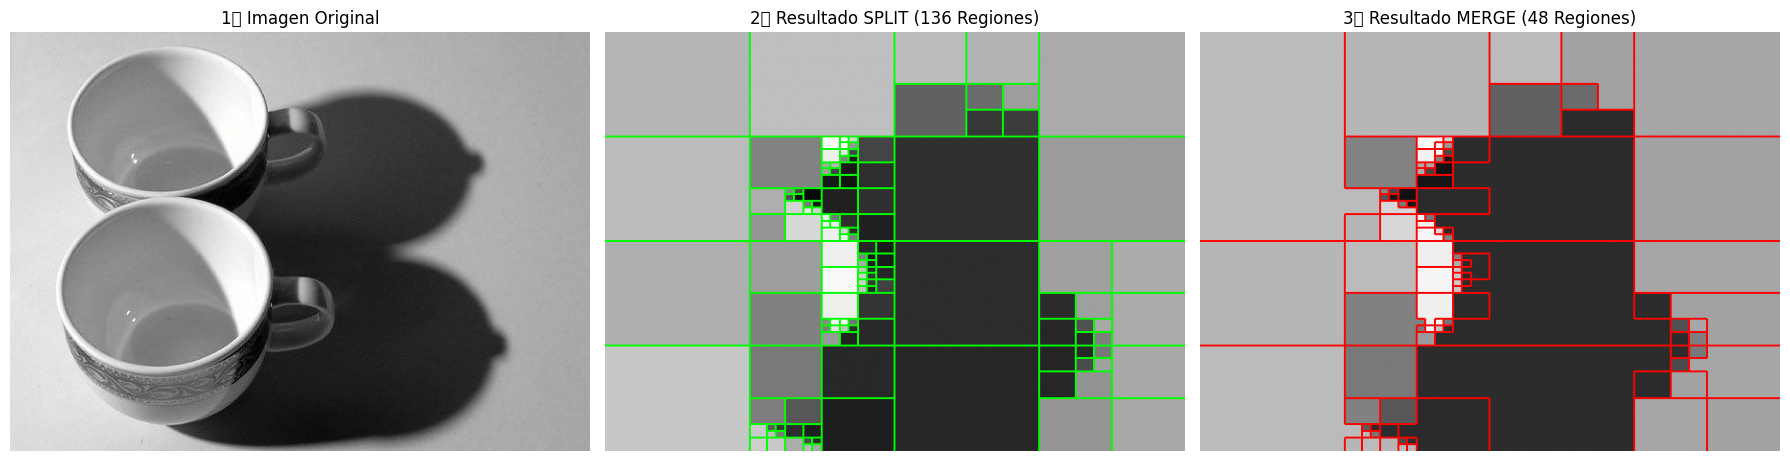

(array([[  1,   1,   1, ...,  57,  57,  57],
        [  1,   1,   1, ...,  57,  57,  57],
        [  1,   1,   1, ...,  57,  57,  57],
        ...,
        [ 95,  95,  95, ..., 136, 136, 136],
        [ 95,  95,  95, ..., 136, 136, 136],
        [ 95,  95,  95, ..., 136, 136, 136]], dtype=uint16),
 array([[40, 40, 40, ..., 48, 48, 48],
        [40, 40, 40, ..., 48, 48, 48],
        [40, 40, 40, ..., 48, 48, 48],
        ...,
        [40, 40, 40, ..., 47, 47, 47],
        [40, 40, 40, ..., 47, 47, 47],
        [40, 40, 40, ..., 47, 47, 47]], dtype=uint16))

In [ ]:
image_tasas = "./tasas.jpg"
run_split_merge_and_graph(
        image_path=image_tasas,
        split_threshold=SPLIT_THRESHOLD,
        merge_threshold=MERGE_THRESHOLD,
        min_quadrant_size=MIN_QUADRANT_SIZE,
        max_iter=MAX_ITER
    )

### Logo

In [ ]:
# Umbral de Varianza (Split): Qué tan estricto para la división inicial.
# Un valor bajo (ej. 50-100) fuerza la división en áreas de bajo contraste.
SPLIT_THRESHOLD = 30

# Umbral de Intensidad Media (Merge): Qué tan parecidas deben ser las regiones adyacentes
# para fusionarse. La intensidad va de 0 a 255.
# Un valor de 10-20 es una buena diferencia para fusionar.
MERGE_THRESHOLD = 20

# Tamaño Mínimo: Para evitar recursión infinita en áreas muy pequeñas.
MIN_QUADRANT_SIZE = 8

MAX_ITER=13

🔹 Ejecutando Split...
✅ Split completado con 298 regiones
🔹 Ejecutando Merge optimizado...
🌀 Iteración 1: 255 regiones
🌀 Iteración 2: 238 regiones
🌀 Iteración 3: 229 regiones
🌀 Iteración 4: 224 regiones
🌀 Iteración 5: 220 regiones
🌀 Iteración 6: 217 regiones
🌀 Iteración 7: 215 regiones
🌀 Iteración 8: 213 regiones
🌀 Iteración 9: 211 regiones
🌀 Iteración 10: 209 regiones
🌀 Iteración 11: 207 regiones
🌀 Iteración 12: 206 regiones
🌀 Iteración 13: 205 regiones
✅ Merge completado con 205 regiones


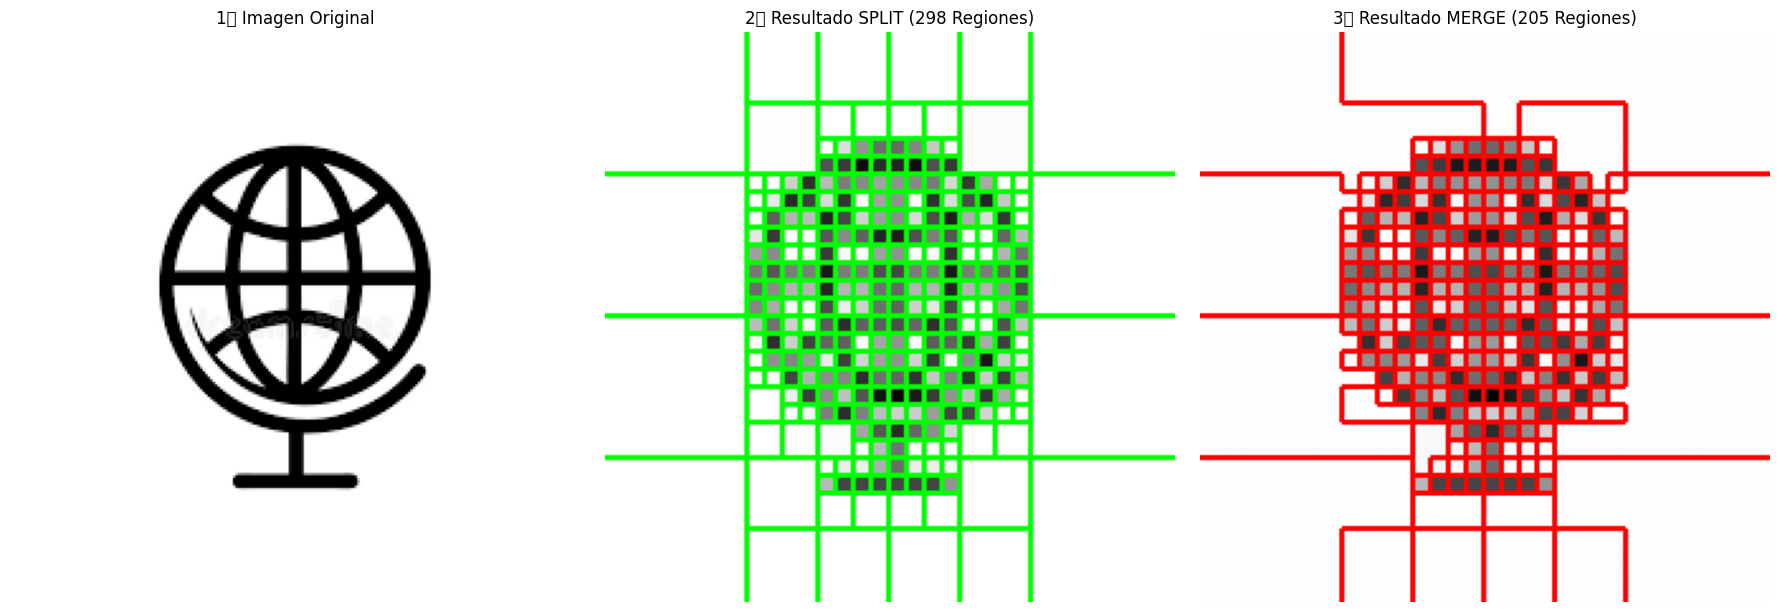

(array([[  1,   1,   1, ...,  93,  93,  93],
        [  1,   1,   1, ...,  93,  93,  93],
        [  1,   1,   1, ...,  93,  93,  93],
        ...,
        [212, 212, 212, ..., 298, 298, 298],
        [212, 212, 212, ..., 298, 298, 298],
        [212, 212, 212, ..., 298, 298, 298]], dtype=uint16),
 array([[204, 204, 204, ..., 205, 205, 205],
        [204, 204, 204, ..., 205, 205, 205],
        [204, 204, 204, ..., 205, 205, 205],
        ...,
        [205, 205, 205, ..., 204, 204, 204],
        [205, 205, 205, ..., 204, 204, 204],
        [205, 205, 205, ..., 204, 204, 204]], dtype=uint16))

In [ ]:
image_parque = "./logo.png"
run_split_merge_and_graph(
        image_path=image_parque,
        split_threshold=SPLIT_THRESHOLD,
        merge_threshold=MERGE_THRESHOLD,
        min_quadrant_size=MIN_QUADRANT_SIZE,
        max_iter=MAX_ITER
    )

### Logo Cuadrado

In [ ]:
# Umbral de Varianza (Split): Qué tan estricto para la división inicial.
# Un valor bajo (ej. 50-100) fuerza la división en áreas de bajo contraste.
SPLIT_THRESHOLD = 20

# Umbral de Intensidad Media (Merge): Qué tan parecidas deben ser las regiones adyacentes
# para fusionarse. La intensidad va de 0 a 255.
# Un valor de 10-20 es una buena diferencia para fusionar.
MERGE_THRESHOLD = 30

# Tamaño Mínimo: Para evitar recursión infinita en áreas muy pequeñas.
MIN_QUADRANT_SIZE = 8

MAX_ITER=42

🔹 Ejecutando Split...
✅ Split completado con 466 regiones
🔹 Ejecutando Merge optimizado...
🌀 Iteración 1: 380 regiones
🌀 Iteración 2: 345 regiones
🌀 Iteración 3: 321 regiones
🌀 Iteración 4: 298 regiones
🌀 Iteración 5: 276 regiones
🌀 Iteración 6: 256 regiones
🌀 Iteración 7: 237 regiones
🌀 Iteración 8: 219 regiones
🌀 Iteración 9: 202 regiones
🌀 Iteración 10: 186 regiones
🌀 Iteración 11: 174 regiones
🌀 Iteración 12: 163 regiones
🌀 Iteración 13: 153 regiones
🌀 Iteración 14: 143 regiones
🌀 Iteración 15: 133 regiones
🌀 Iteración 16: 123 regiones
🌀 Iteración 17: 114 regiones
🌀 Iteración 18: 107 regiones
🌀 Iteración 19: 101 regiones
🌀 Iteración 20: 95 regiones
🌀 Iteración 21: 90 regiones
🌀 Iteración 22: 86 regiones
🌀 Iteración 23: 83 regiones
🌀 Iteración 24: 80 regiones
🌀 Iteración 25: 77 regiones
🌀 Iteración 26: 75 regiones
🌀 Iteración 27: 73 regiones
🌀 Iteración 28: 71 regiones
🌀 Iteración 29: 70 regiones
🌀 Iteración 30: 69 regiones
🌀 Iteración 31: 68 regiones
🌀 Iteración 32: 67 regiones
🌀 I

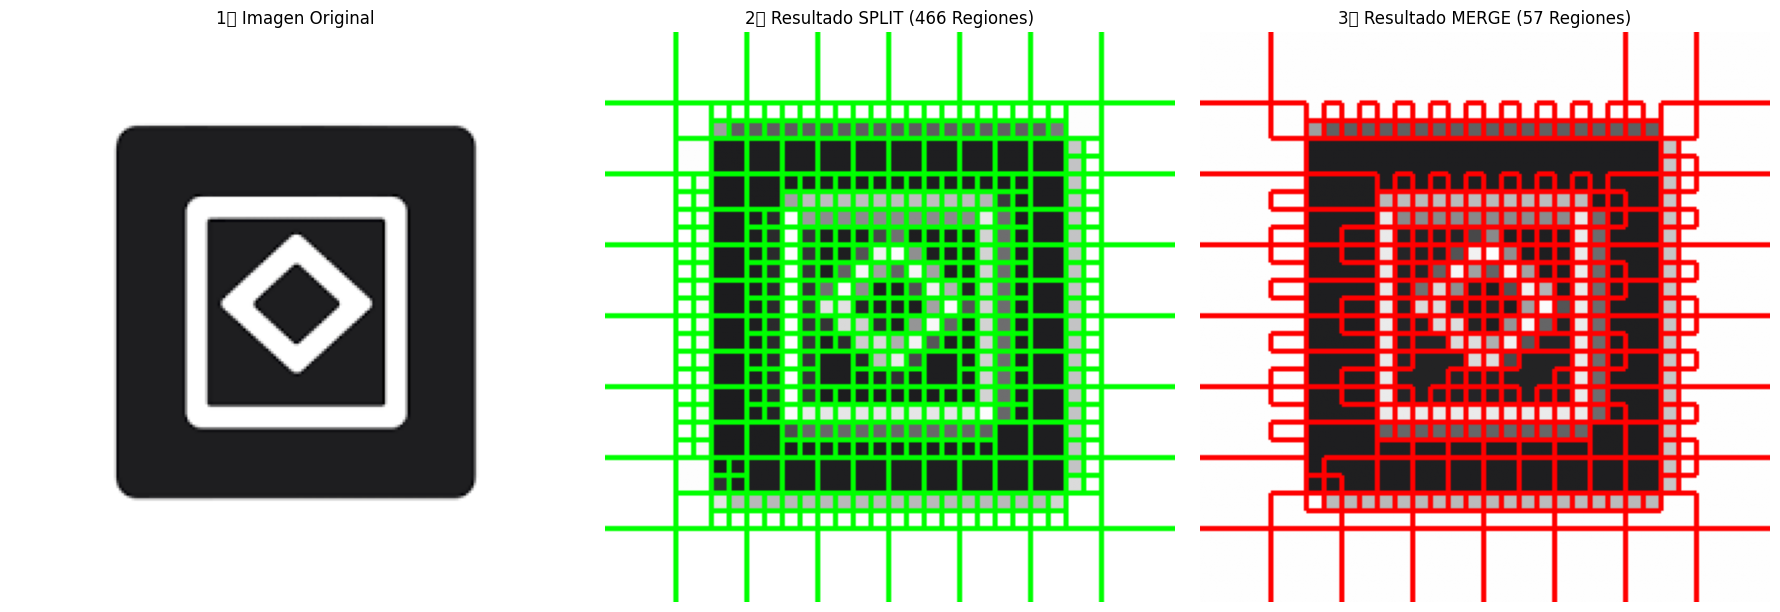

(array([[  1,   1,   1, ..., 139, 139, 139],
        [  1,   1,   1, ..., 139, 139, 139],
        [  1,   1,   1, ..., 139, 139, 139],
        ...,
        [328, 328, 328, ..., 466, 466, 466],
        [328, 328, 328, ..., 466, 466, 466],
        [328, 328, 328, ..., 466, 466, 466]], dtype=uint16),
 array([[57, 57, 57, ..., 56, 56, 56],
        [57, 57, 57, ..., 56, 56, 56],
        [57, 57, 57, ..., 56, 56, 56],
        ...,
        [56, 56, 56, ..., 57, 57, 57],
        [56, 56, 56, ..., 57, 57, 57],
        [56, 56, 56, ..., 57, 57, 57]], dtype=uint16))

In [ ]:
image_parque = "./logo_cuadrado.png"
run_split_merge_and_graph(
        image_path=image_parque,
        split_threshold=SPLIT_THRESHOLD,
        merge_threshold=MERGE_THRESHOLD,
        min_quadrant_size=MIN_QUADRANT_SIZE,
        max_iter=MAX_ITER
    )